In [1]:
from shapes import Point, Rectangle
from environment import Environment2D
from utils import PlotTools
from graph import Graph
from lqr import LQRPlanner
from simulate import Simulator
from plan import Plan, PlanUtils
from search import Searcher

import matplotlib.pyplot as plt
import numpy as np
import polytope as pc
%load_ext autoreload
%autoreload 2

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


In [2]:
# def generate_waypoints(A, B, x_0, u_nom):
#     T = u_nom.shape[0]
#     x_nom = np.zeros((T, A.shape[0]))
#     x_nom[0] = x_0
#     for t in range(1, T):
#         x_nom[t] = np.dot(A, x_nom[t - 1]) + np.dot(B, u_nom[t - 1])
#     return x_nom

# Env 0

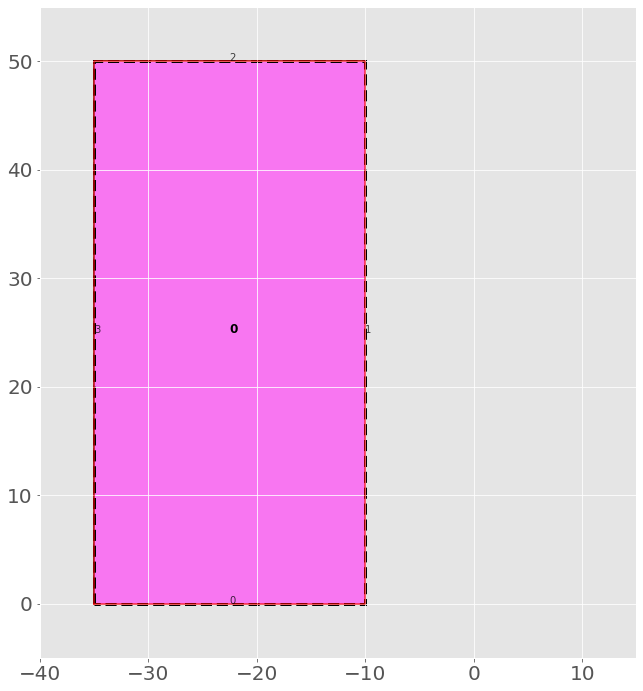

In [38]:
x_lims = [-40,15]
y_lims = [-5,55]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -35,0,25,50,0)
# rec_0.set_error_bounds(np.array([0,-5,0,0]), np.array([0,5,0,0]))
# rec_0.set_actual_errors(np.array([0,-4,0,0]))
# rec_0.set_actual_errors(np.array([0,4,0,0]))
fig, ax = plt.subplots()
env.add_rectangles([rec_0])
env.plot(ax=ax)
env.rectangles[0].as_poly["actual"].plot(ax=ax)

In [80]:
dt = 0.2
A = np.eye(2); B = dt*np.eye(2)
Q_lqr = np.eye(2)
R_lqr = 0.1*np.eye(2)
lqr_planner = LQRPlanner(Q_lqr, R_lqr, A, B)

dx = 1
Q = np.eye(2) * 0.1
R = 1
T = 50
x0 = [0,0]
x_noms = np.zeros((T,2))
x_noms[:,1] = np.arange(0,T*dx, dx)
u_noms = np.zeros((T,2))
u_noms[:,1] = np.ones(T) * (dx/dt)

x_est_0 = x0
P_est_0 = np.eye(2)

### Simulator stuff

In [6]:
sim = Simulator(env)
sim.set_motion(A, B, Q)
sim.set_obs(R)
sim.set_gain(lqr_planner.gain)
sim.set_init_est(x_est_0, P_est_0)
num_iters = 100
xs, x_ests, x_bars = sim.run(num_iters, x0, P_est_0, x_noms, u_noms)

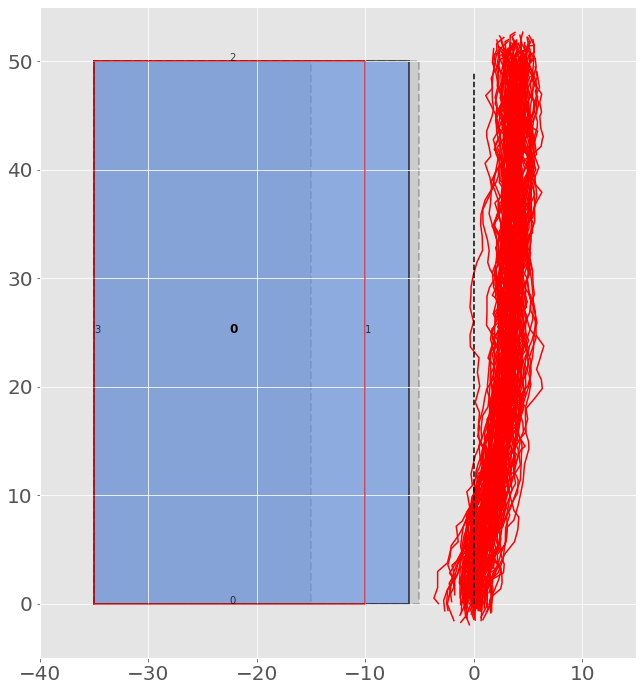

In [7]:
env.plot()
Point(x0[0],x0[1]).plot()
sim.plot_trajs(xs, x_noms)

### Graph exploration

In [81]:
x_range = np.array([x_lims, y_lims])
nsamples = 50
tol = 1e-2
g = Graph(x0, x_range, env, lqr_planner)
g.clear()

In [82]:
samples_all = np.load("samples.dat", allow_pickle=True)
samples_manual = []
for i in [0,22,8,17,18,23,13,47,10,29,11]:
    samples_manual.append(samples_all[i,:2])
samples_manual = np.array(samples_manual)
g.set_samples(samples_manual)

In [ ]:
# g.set_samples(samples_all)

In [85]:
g.build(50, r=120, max_neighbors=None, bidir=False, tol=tol)

Connecting took: 0.04 s.


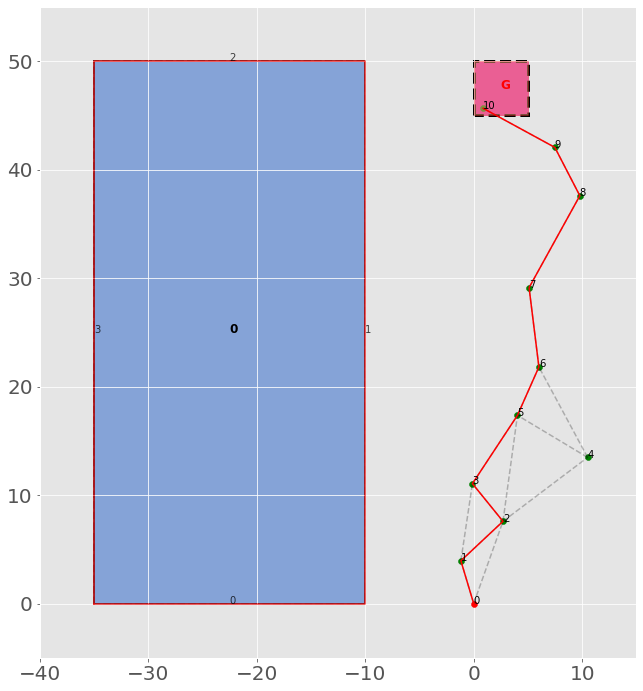

In [96]:
fig, ax = plt.subplots()
goal_region = Rectangle(-1, 0,45,5,5,0)
g.plot(ax=ax, show_idx=True)
goal_region.plot(ax=ax,as_goal=True)
goal_region.as_poly["original"].plot(ax=ax)
PlotTools.plot_traj(g.indices2path(plan_found.path_indices))

In [107]:
g.edges[1][2][0]

30.535877058455274

In [91]:
g.edges[4].keys()

dict_keys([5, 6])

In [7]:
# scaling_factors = [6,4,3,2,1]
# confid_sets_test = Xks[0].get_confidence_sets(scaling_factors)

In [8]:
# fig, ax = plt.subplots()
# env.plot(ax=ax)
# # rec_test.to_poly().plot(ax=ax)
# # confid_sets_test[0].to_poly().plot(ax=ax)
# # confid_sets_test[1].to_poly().plot(ax=ax)
# # confid_sets_test[2].to_poly().plot(ax=ax)
# # confid_sets_test[3].to_poly().plot(ax=ax)
# # confid_sets_test[4].to_poly().plot(ax=ax)

# Point(-0.1689,0.08943).plot()

In [93]:
R = 0.1
kmax = 100
lambda_coeff = 1.0
searcher = Searcher(g, lambda_coeff * g.r)
searcher.set_source()
searcher.initialize_open(Q, R, P_est_0, kmax)
searcher.set_goal(goal_region.as_poly["original"])

In [94]:
P_candidates, plan_found = searcher.explore(0.2)

========== p = [0. 0.] at index 0 ==========
NEIGHBORS: dict_keys([1, 2])
----- neighbor_idx = 1 -----


/home/zhangvwk/Documents/us/Stanford/quarters/spring20/indep/code/planning-with-map-errors/zonotope.py:71: RuntimeWarning: invalid value encountered in true_divide
  Cpi = gg / np.linalg.norm(gg)
/home/zhangvwk/.local/lib/python3.6/site-packages/polytope/polytope.py:126: RuntimeWarning: invalid value encountered in greater
  pos = np.nonzero(Anorm > 1e-10)[0]


adding to P and P_open
----- neighbor_idx = 2 -----
adding to P and P_open
========== p = [2.70044 7.58171] at index 2 ==========
NEIGHBORS: dict_keys([3, 4, 5])
----- neighbor_idx = 3 -----
adding to P and P_open
----- neighbor_idx = 4 -----
adding to P and P_open
----- neighbor_idx = 5 -----
adding to P and P_open
========== p = [-1.18125  3.9446 ] at index 1 ==========
NEIGHBORS: dict_keys([2, 3])
----- neighbor_idx = 2 -----
adding to P and P_open
----- neighbor_idx = 3 -----
adding to P and P_open
========== p = [-0.11752 11.05844] at index 3 ==========
NEIGHBORS: dict_keys([5])
----- neighbor_idx = 5 -----
adding to P and P_open
========== p = [ 4.03477 17.35501] at index 5 ==========
NEIGHBORS: dict_keys([6])
----- neighbor_idx = 6 -----
adding to P and P_open
========== p = [10.50276 13.47557] at index 4 ==========
NEIGHBORS: dict_keys([5, 6])
----- neighbor_idx = 5 -----
adding to P and P_open
----- neighbor_idx = 6 -----
adding to P and P_open
========== p = [2.70044 7.58171]

In [95]:
for p in P_candidates:
    print("path: {}".format(p.path_indices))
    print("cost: {}".format(p.cost))

path: [0, 1, 2, 4, 6, 7, 8, 9, 10]
cost: 496.8005542411207
path: [0, 1, 2, 5, 6, 7, 8, 9, 10]
cost: 427.5078456528202
path: [0, 2, 5, 6, 7, 8, 9, 10]
cost: 448.5766810679543
path: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10]
cost: 487.07814768799466
path: [0, 1, 3, 5, 6, 7, 8, 9, 10]
cost: 409.1973316727377
path: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10]
cost: 405.5134958448794
path: [0, 2, 4, 6, 7, 8, 9, 10]
cost: 517.8693896562548
path: [0, 2, 4, 5, 6, 7, 8, 9, 10]
cost: 508.1469831031288
path: [0, 2, 3, 5, 6, 7, 8, 9, 10]
cost: 426.5823312600135


In [98]:
plan_found.path_indices

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10]

In [99]:
plan_found.cost

405.5134958448794

# Env 1

In [321]:
x_lims = [-10,10]
y_lims = [-5,5]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -6.5,-3,3,5,0)
rec_1 = Rectangle(1, 1,-1,3,3,0)
rec_2 = Rectangle(2, -10,5,20,1,0)
rec_3 = Rectangle(3, -10,-6.5,20,1,0)
rec_4 = Rectangle(4, -2.5,4.5,5,0.5,0)

rec_0.set_error_bounds(np.array([0,0,0,0]), np.array([0,1.5,1.5,0]))
rec_1.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,1.5,0]))
rec_2.set_error_bounds(np.array([-0.5,0,0,0]), np.array([0.5,0,0,0]))

rec_0.set_actual_errors(np.array([0,0,1.5,0]))
rec_1.set_actual_errors(np.array([0,0,1.5,0]))
rec_2.set_actual_errors(np.array([-0.5,0,0,0]))

env.add_rectangles([rec_0, rec_1, rec_2, rec_3])
# env.add_rectangles([rec_0, rec_1, rec_2, rec_3, rec_4])
# env.add_rectangles([rec_0, rec_1, rec_3])

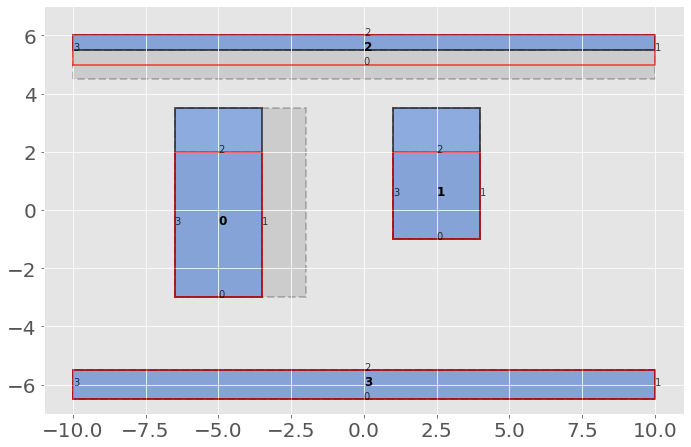

In [322]:
env.plot()

In [323]:
dt = 0.2
A = np.eye(2); B = dt*np.eye(2)
Q_lqr = 10*np.eye(2)
R_lqr = np.eye(2)
lqr_planner = LQRPlanner(Q_lqr, R_lqr, A, B)

Q = np.eye(2) * 0.001
R = 0.1
T = 280
u_noms = np.zeros((T - 1, 2))
for t in range(T - 1):
    u_noms[t] = [0.3, 0]
x0 = [-9, 3.8]
x_noms = generate_waypoints(A, B, x0, u_noms)

x_est_0 = x0
P_est_0 = np.eye(2)

sim = Simulator(env)
sim.set_motion(A, B, Q)
sim.set_obs(R)
sim.set_gain(lqr_planner.lqr_gain)
sim.set_init_est(x_est_0, P_est_0)

In [324]:
# xs = sim.rollout(x0, x_noms, u_noms)

In [325]:
num_iters = 20
xs, x_ests, x_bars = sim.run(num_iters, x0, 0.0*np.eye(2), x_noms, u_noms)

100%|██████████| 20/20 [00:33<00:00,  1.66s/it]


In [63]:
# sim.plot_trajs(xs, x_noms)

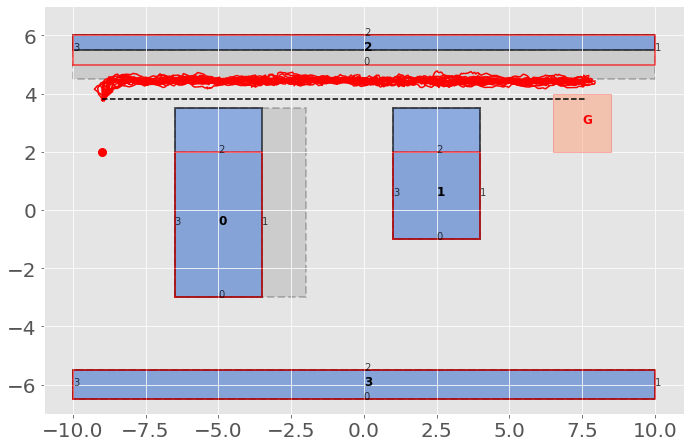

In [326]:
env.plot()
x_start = Point(-9, 2)
x_start.plot()
goal_region = Rectangle(-1, 6.5,2,2,2,0)
goal_region.plot(as_goal=True)
sim.plot_trajs(xs, x_noms)

# Env 2

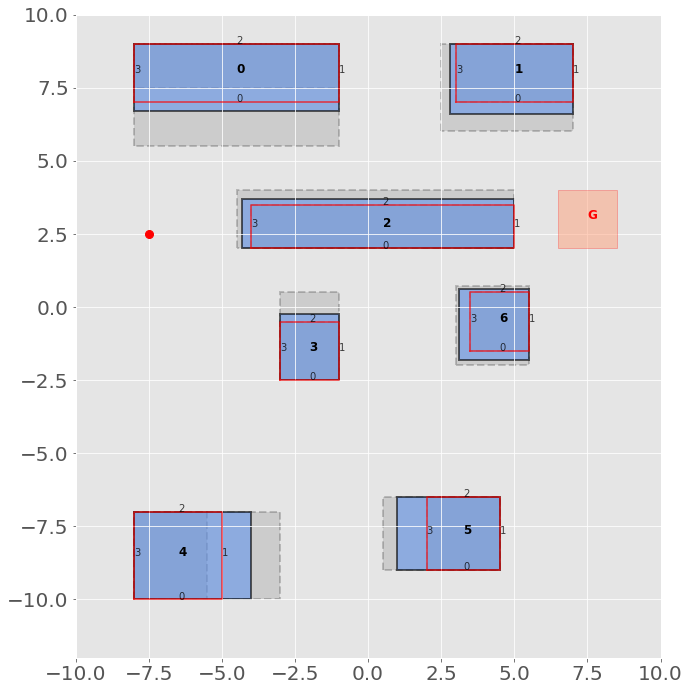

In [37]:
x_lims = [-10,10]
y_lims = [-12,10]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -8,7,7,2,0)
rec_1 = Rectangle(1, 3,7,4,2,0)
rec_2 = Rectangle(2, -4,2,9,1.5,0)
rec_3 = Rectangle(3, -3,-2.5,2,2,0)
rec_4 = Rectangle(4, -8,-10,3,3,0)
rec_5 = Rectangle(5, 2,-9,2.5,2.5,0)
rec_6 = Rectangle(6, 3.5,-1.5,2,2,0)

rec_0.set_error_bounds(np.array([-0.5,0,0,0]), np.array([1.5,0,0,0]))
rec_1.set_error_bounds(np.array([0,0,0,0]), np.array([1,0,0,0.5]))
rec_2.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,0.5,0.5]))
rec_3.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,1,0]))
rec_4.set_error_bounds(np.array([0,-0.5,0,0]), np.array([0,2,0,0]))
rec_5.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,0,1.5]))
rec_6.set_error_bounds(np.array([0,0,0,0]), np.array([0.5,0,0.2,0.5]))

rec_0.set_actual_errors(np.array([0.3,0,0,0]))
rec_1.set_actual_errors(np.array([0.4,0,0,0.2]))
rec_2.set_actual_errors(np.array([0,0,0.2,0.3]))
rec_3.set_actual_errors(np.array([0,0,0.25,0]))
rec_4.set_actual_errors(np.array([0,1,0,0]))
rec_5.set_actual_errors(np.array([0,0,0,1]))
rec_6.set_actual_errors(np.array([0.3,0,0.1,0.4]))

env.add_rectangles([rec_0, rec_1, rec_2, rec_3, rec_4, rec_5, rec_6])

env.plot()
x_start = Point(-7.5, 2.5)
x_start.plot()
goal_region = Rectangle(-1, 6.5,2,2,2,0)
goal_region.plot(as_goal=True)